DEBUG: Total recipes extracted: 58
DEBUG: Sample recipe: {'machine': 'Ore Excavator', 'output': 'titanium_ore', 'inputs': {}}
DEBUG: Recipe counts by machine:
  Assembler: 8 recipes
  Compounder: 6 recipes
  Fabricator: 12 recipes
  Furnace: 12 recipes
  Mega Press: 10 recipes
  Ore Excavator: 5 recipes
  Refinery: 2 recipes
  Smelter: 3 recipes
DEBUG: Helium found. Current level: 0
DEBUG: Helium set to level 2. Now recalculating dependent materials...
DEBUG: Updated pressurized_helium from level 1 to level 3
DEBUG: Recalculation complete after 2 iterations


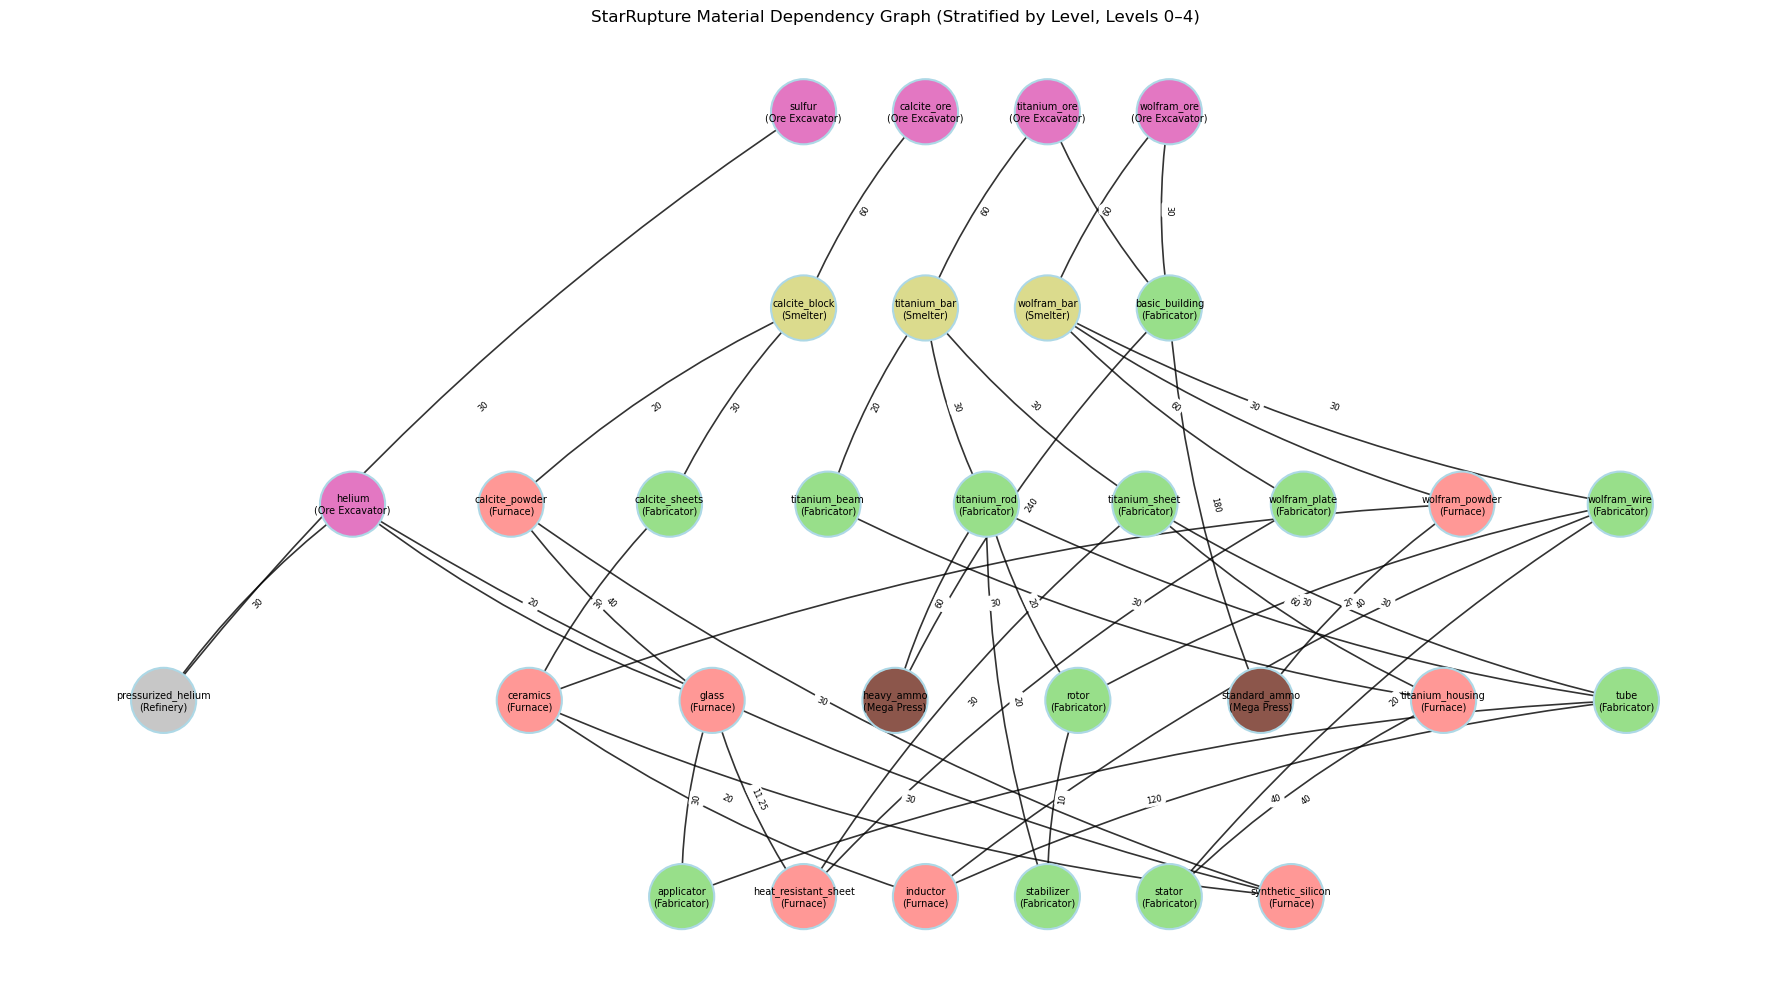

Level 0 (4 items):
  - calcite_ore
  - sulfur
  - titanium_ore
  - wolfram_ore

Level 1 (4 items):
  - basic_building
  - calcite_block
  - titanium_bar
  - wolfram_bar

Level 2 (9 items):
  - calcite_powder
  - calcite_sheets
  - helium
  - titanium_beam
  - titanium_rod
  - titanium_sheet
  - wolfram_plate
  - wolfram_powder
  - wolfram_wire

Level 3 (8 items):
  - ceramics
  - glass
  - heavy_ammo
  - pressurized_helium
  - rotor
  - standard_ammo
  - titanium_housing
  - tube

Level 4 (6 items):
  - applicator
  - heat_resistant_sheet
  - inductor
  - stabilizer
  - stator
  - synthetic_silicon



In [ ]:
import json
import math
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Range1d, LabelSet
from bokeh.palettes import Category20


JSON_PATH = "recipes_2_simplified.json"


def _extract_recipes(data):
    """Normalize recipes from the JSON into a list of dicts."""
    recipes = []

    def looks_like_recipe(obj):
        if not isinstance(obj, dict):
            return False
        keys = set(obj.keys())
        has_out = any(k in keys for k in ("output", "out", "result", "produces"))
        has_in = any(k in keys for k in ("inputs", "in", "ingredients", "requires", "cost"))
        return has_out and has_in

    def get_output(obj):
        for k in ("output", "out", "result", "produces"):
            if k in obj:
                out = obj[k]
                if isinstance(out, dict) and "id" in out:
                    return out["id"]
                return out
        return None

    def get_inputs(obj):
        for k in ("inputs", "in", "ingredients", "requires", "cost"):
            if k in obj:
                return obj[k]
        return None

    def get_machine(obj):
        for k in ("machine", "building", "station", "producer"):
            if k in obj and isinstance(obj[k], str):
                return obj[k]
        return None

    def normalize_inputs(inp):
        if inp is None:
            return {}
        if isinstance(inp, dict):
            norm = {}
            for k, v in inp.items():
                try:
                    norm[str(k)] = float(v)
                except Exception:
                    norm[str(k)] = 1.0
            return norm
        if isinstance(inp, list):
            norm = {}
            for el in inp:
                if isinstance(el, dict):
                    item = el.get("id") or el.get("item") or el.get("name") or el.get("material")
                    amt = el.get("amount_per_minute") or el.get("amount") or el.get("qty") or el.get("count") or 1
                    if item is not None:
                        try:
                            norm[str(item)] = float(amt)
                        except Exception:
                            norm[str(item)] = 1.0
                elif isinstance(el, (list, tuple)) and len(el) >= 1:
                    item = el[0]
                    amt = el[1] if len(el) > 1 else 1
                    try:
                        norm[str(item)] = float(amt)
                    except Exception:
                        norm[str(item)] = 1.0
            return norm
        return {}

    def crawl(obj, current_machine=None):
        nonlocal recipes
        if isinstance(obj, dict):
            machine = current_machine
            for k in ("machine", "building", "station", "name", "id"):
                if k in obj and isinstance(obj[k], str):
                    machine = obj[k]
                    break

            if looks_like_recipe(obj):
                out = get_output(obj)
                inp = normalize_inputs(get_inputs(obj))
                m = get_machine(obj) or current_machine
                if out is not None:
                    recipes.append({"machine": m, "output": str(out), "inputs": inp})

            for v in obj.values():
                crawl(v, machine)

        elif isinstance(obj, list):
            for v in obj:
                crawl(v, current_machine)

    crawl(data, None)

    uniq = []
    seen = set()
    for r in recipes:
        key = (r["machine"], r["output"], tuple(sorted(r["inputs"].items())))
        if key not in seen:
            seen.add(key)
            uniq.append(r)
    return uniq


def compute_levels(recipes):
    produced_by = defaultdict(list)
    all_materials = set()

    for r in recipes:
        out = r["output"]
        ins = set(r["inputs"].keys())
        produced_by[out].append(r)
        all_materials.add(out)
        all_materials |= ins

    level = {m: None for m in all_materials}

    for m, rs in produced_by.items():
        if any(len(r["inputs"]) == 0 for r in rs):
            level[m] = 0

    changed = True
    for _ in range(10_000):
        if not changed:
            break
        changed = False
        for m, rs in produced_by.items():
            if level[m] == 0:
                continue
            candidates = []
            for r in rs:
                ins = r["inputs"]
                if len(ins) == 0:
                    candidates.append(0)
                    continue
                in_levels = []
                ok = True
                for i in ins.keys():
                    if level[i] is None:
                        ok = False
                        break
                    in_levels.append(level[i])
                if ok:
                    candidates.append(1 + max(in_levels))
            if candidates:
                new_lvl = min(candidates)
                if level[m] is None or new_lvl < level[m]:
                    level[m] = new_lvl
                    changed = True
    return level


def build_dependency_graph(recipes):
    G = nx.DiGraph()
    for r in recipes:
        out = r["output"]
        G.add_node(out)
        for inp, qty in r["inputs"].items():
            G.add_node(inp)
            if G.has_edge(inp, out):
                G.edges[inp, out]["recipes"].append({"machine": r["machine"], "qty": qty})
            else:
                G.add_edge(inp, out, recipes=[{"machine": r["machine"], "qty": qty}])
    return G


def layered_positions(nodes_by_level, G):
    """Deterministic layered layout."""
    pos = {}
    for lvl, nodes in sorted(nodes_by_level.items()):
        if lvl == 0:
            nodes_sorted = sorted(nodes)
            if "helium" in nodes_sorted:
                nodes_sorted.remove("helium")
            if "sulfur" in nodes_sorted:
                nodes_sorted.remove("sulfur")
                nodes_sorted = ["sulfur"] + nodes_sorted
            n = len(nodes_sorted)
            for i, node in enumerate(nodes_sorted):
                x = i - (n - 1) / 2
                y = -lvl
                pos[node] = (x, y)
        elif lvl == 1:
            nodes_sorted = sorted(nodes)
            if "block_calcium" in nodes_sorted:
                nodes_sorted.remove("block_calcium")
            if "basic_building" in nodes_sorted:
                nodes_sorted.remove("basic_building")
            final_order = []
            if "block_calcium" in nodes:
                final_order.append("block_calcium")
            final_order.extend(nodes_sorted)
            if "basic_building" in nodes:
                final_order.append("basic_building")
            n = len(final_order)
            for i, node in enumerate(final_order):
                x = i - (n - 1) / 2
                y = -lvl
                pos[node] = (x, y)
        elif lvl == 2:
            level2_nodes = sorted(nodes)
            if "helium" in level2_nodes:
                level2_nodes.remove("helium")
                level2_nodes = ["helium"] + level2_nodes
            spacing = 1.3
            n = len(level2_nodes)
            for i, node in enumerate(level2_nodes):
                x = (i - (n - 1) / 2) * spacing
                y = -lvl
                pos[node] = (x, y)
        elif lvl == 3:
            level3_nodes = sorted(nodes)
            spacing = 1.5
            if "pressurized_helium" in level3_nodes:
                level3_nodes.remove("pressurized_helium")
            n = len(level3_nodes)
            pressurized_x = -(n * spacing) / 2 - spacing
            pos["pressurized_helium"] = (pressurized_x, -lvl)
            for i, node in enumerate(level3_nodes):
                centered = i * spacing - (n - 1) * spacing / 2
                x = centered + spacing / 2
                y = -lvl
                pos[node] = (x, y)
        else:
            nodes = sorted(nodes)
            n = len(nodes)
            for i, node in enumerate(nodes):
                x = i - (n - 1) / 2
                y = -lvl
                pos[node] = (x, y)
    return pos


def _bokeh_sources(G, pos, edge_labels):
    machines = sorted({G.nodes[n].get("machine", "Unknown") for n in G.nodes()})
    palette = Category20[20] if len(machines) <= 20 else Category20[20] * ((len(machines) // 20) + 1)
    machine_to_color = {m: palette[i % len(palette)] for i, m in enumerate(machines)}

    node_rows = []
    for n in G.nodes():
        x, y = pos[n]
        machine = G.nodes[n].get("machine", "Unknown")
        level = G.nodes[n].get("level", "?")
        label = f"{n} ({machine})" if machine != "Gathered" else n
        node_rows.append({
            "name": n,
            "x": x,
            "y": y,
            "machine": machine,
            "level": level,
            "color": machine_to_color.get(machine, "#808080"),
            "label": label,
            "in_degree": G.in_degree(n),
            "out_degree": G.out_degree(n),
        })

    edge_xs = []
    edge_ys = []
    start_labels = []
    end_labels = []
    edge_qty_labels = []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_xs.append([x0, x1])
        edge_ys.append([y0, y1])
        start_labels.append(u)
        end_labels.append(v)
        edge_qty_labels.append(edge_labels.get((u, v), ""))

    node_source = ColumnDataSource(node_rows)
    edge_source = ColumnDataSource({
        "xs": edge_xs,
        "ys": edge_ys,
        "start": start_labels,
        "end": end_labels,
        "label": edge_qty_labels,
    })
    return node_source, edge_source, machine_to_color


def render_bokeh_graph(G, pos, edge_labels):
    output_notebook()

    node_source, edge_source, machine_to_color = _bokeh_sources(G, pos, edge_labels)

    all_x = [x for coords in node_source.data["x"] for x in ([coords] if not isinstance(coords, list) else coords)]
    all_y = [y for coords in node_source.data["y"] for y in ([coords] if not isinstance(coords, list) else coords)]
    x_min, x_max = min(all_x) - 1.0, max(all_x) + 1.0
    y_min, y_max = min(all_y) - 1.0, max(all_y) + 1.0

    p = figure(
        width=1200,
        height=720,
        title="StarRupture Material Dependency Graph (Bokeh, Levels 0–4)",
        tools="pan,wheel_zoom,box_zoom,reset,save,hover, tap",
        active_scroll="wheel_zoom",
        x_range=Range1d(x_min, x_max),
        y_range=Range1d(y_min, y_max),
        match_aspect=True,
    )

    p.multi_line(
        xs="xs",
        ys="ys",
        source=edge_source,
        line_color="#7a7a7a",
        line_alpha=0.65,
        line_width=2,
    )

    renderer = p.circle(
        x="x",
        y="y",
        size=18,
        source=node_source,
        fill_color="color",
        line_color="white",
        line_width=1.2,
        hover_fill_color="color",
        hover_line_color="#222",
        hover_line_width=2,
        selection_line_color="#222",
        selection_line_width=2,
    )

    labels = LabelSet(
        x="x",
        y="y",
        text="label",
        source=node_source,
        text_font_size="8pt",
        text_align="center",
        text_baseline="middle",
        y_offset=-18,
    )
    p.add_layout(labels)

    hover = p.select_one(HoverTool)
    if hover:
        hover.tooltips = [
            ("material", "@name"),
            ("machine", "@machine"),
            ("level", "@level"),
            ("in -> out", "@in_degree -> @out_degree"),
        ]
        hover.renderers = [renderer]
        hover.point_policy = "follow_mouse"

    edge_hover = HoverTool(
        tooltips=[
            ("edge", "@start → @end"),
            ("qty/recipes", "@label"),
        ],
        renderers=[],
        line_policy="nearest",
        point_policy="none",
    )
    p.add_tools(edge_hover)

    show(p)


def main():
    with open(JSON_PATH, "r") as f:
        data = json.load(f)

    recipes = _extract_recipes(data)
    if not recipes:
        raise RuntimeError("No recipes detected in JSON (unexpected structure).")

    levels = compute_levels(recipes)
    G_full = build_dependency_graph(recipes)

    resolved = {m: lvl for m, lvl in levels.items() if isinstance(lvl, int)}

    if "helium" in resolved:
        print(f"DEBUG: Helium found. Current level: {resolved['helium']}")
        resolved["helium"] = 2
        print("DEBUG: Helium set to level 2. Now recalculating dependent materials...")
        produced_by = defaultdict(list)
        for r in recipes:
            produced_by[r["output"]].append(r)
        changed = True
        iterations = 0
        max_iterations = 10000
        while changed and iterations < max_iterations:
            changed = False
            iterations += 1
            for material in list(resolved.keys()):
                recipe_list = produced_by.get(material, [])
                if any(len(r["inputs"]) == 0 for r in recipe_list):
                    continue
                if not recipe_list:
                    continue
                candidates = []
                for r in recipe_list:
                    in_levels = []
                    for inp in r["inputs"].keys():
                        in_level = resolved.get(inp, 0)
                        in_levels.append(in_level)
                    if in_levels:
                        candidates.append(1 + max(in_levels))
                if candidates:
                    new_level = min(candidates)
                    old_level = resolved[material]
                    if new_level != old_level:
                        resolved[material] = new_level
                        changed = True
                        if material in ["pressurized_helium", "glass", "chemicals", "synthetic_silicon", "nozzle"]:
                            print(f"DEBUG: Updated {material} from level {old_level} to level {new_level}")
        print(f"DEBUG: Recalculation complete after {iterations} iterations")

    keep = {m for m, lvl in resolved.items() if lvl <= 4}

    G = G_full.subgraph(keep).copy()

    nx.set_node_attributes(G, {m: resolved[m] for m in G.nodes()}, "level")

    material_to_machine = {}
    for r in recipes:
        material_to_machine[r["output"]] = r["machine"] or "Gathered"
    nx.set_node_attributes(G, material_to_machine, "machine")

    nodes_by_level = defaultdict(list)
    for n in G.nodes():
        nodes_by_level[G.nodes[n]["level"]].append(n)

    if "helium" in nodes_by_level[0]:
        nodes_by_level[0].remove("helium")
        if 2 not in nodes_by_level:
            nodes_by_level[2] = []
        nodes_by_level[2].append("helium")
        G.nodes["helium"]["level"] = 2

    pos = layered_positions(nodes_by_level, G)

    edge_labels = {}
    for u, v, d in G.edges(data=True):
        rs = d.get("recipes", [])
        if len(rs) == 1:
            q = rs[0]["qty"]
            edge_labels[(u, v)] = f"{q:g}"
        else:
            edge_labels[(u, v)] = f"{len(rs)} recipes"

    render_bokeh_graph(G, pos, edge_labels)

    for lvl in range(0, 5):
        items = sorted([m for m, L in resolved.items() if L == lvl])
        print(f"Level {lvl} ({len(items)} items):")
        for m in items:
            print(f"  - {m}")
        print()


with open(JSON_PATH, "r") as f:
    data = json.load(f)

recipes = _extract_recipes(data)
print(f"DEBUG: Total recipes extracted: {len(recipes)}")
if recipes:
    print(f"DEBUG: Sample recipe: {recipes[0]}")
    from collections import Counter
    machine_counts = Counter(r['machine'] for r in recipes)
    print("DEBUG: Recipe counts by machine:")
    for machine, count in sorted(machine_counts.items()):
        print(f"  {machine}: {count} recipes")
else:
    print("DEBUG: ERROR - No recipes extracted!")

if __name__ == "__main__":
    main()


In [16]:
# Debug: Check specific materials and their computed levels
print("Checking specific materials and their dependencies:")
print()

# Check pressurized_helium
print("pressurized_helium:")
for r in recipes:
    if r["output"] == "pressurized_helium":
        print(f"  Recipe from {r['machine']}")
        print(f"  Inputs: {r['inputs']}")
print()

# Check glass
print("glass:")
for r in recipes:
    if r["output"] == "glass":
        print(f"  Recipe from {r['machine']}")
        print(f"  Inputs: {r['inputs']}")
print()

# Show all materials with "helium" in their inputs
print("All materials that depend on helium:")
for r in recipes:
    if "helium" in r["inputs"]:
        print(f"  {r['output']} from {r['machine']} (depends on: {list(r['inputs'].keys())})")


Checking specific materials and their dependencies:

pressurized_helium:
  Recipe from Refinery
  Inputs: {'helium': 30.0, 'sulfur': 30.0}

glass:
  Recipe from Furnace
  Inputs: {'helium': 20.0, 'calcite_powder': 40.0}

All materials that depend on helium:
  pressurized_helium from Refinery (depends on: ['helium', 'sulfur'])
  glass from Furnace (depends on: ['helium', 'calcite_powder'])
  synthetic_silicon from Furnace (depends on: ['calcite_powder', 'helium', 'ceramics'])
  chemicals from Furnace (depends on: ['synthetic_silicon', 'wolfram_powder', 'helium'])
  nozzle from Mega Press (depends on: ['helium', 'heat_resistant_sheet', 'stabilizer'])


In [4]:
# Check what level electronics is at
print("Electronics level:", levels_dict.get("electronics"))
print()

# Find recipes that produce electronics
print("Recipes that produce electronics:")
for r in recipes:
    if r["output"] == "electronics":
        print(f"  Machine: {r['machine']}")
        print(f"  Inputs: {r['inputs']}")
print()

# Find recipes that use electronics as input
print("Recipes that use electronics as input:")
found_any = False
for r in recipes:
    if "electronics" in r["inputs"]:
        print(f"  Output: {r['output']}")
        print(f"  Machine: {r['machine']}")
        print(f"  Input qty: {r['inputs']['electronics']}")
        found_any = True
if not found_any:
    print("  (none found)")


NameError: name 'levels_dict' is not defined

## Backup: Levels 0–3 Visualization (Original)

In [ ]:
def main_levels_0_to_3():
    """
    Backup: Original visualization showing levels 0–3 only.
    Call this to recreate the original stratified graph.
    """
    with open(JSON_PATH, "r") as f:
        data = json.load(f)

    recipes = _extract_recipes(data)
    if not recipes:
        raise RuntimeError("No recipes detected in JSON (unexpected structure).")

    levels = compute_levels(recipes)
    G_full = build_dependency_graph(recipes)

    # Keep only materials with resolved levels
    resolved = {m: lvl for m, lvl in levels.items() if isinstance(lvl, int)}
    # Restrict to levels <= 3
    keep = {m for m, lvl in resolved.items() if lvl <= 3}

    G = G_full.subgraph(keep).copy()

    # Attach level as node attribute
    nx.set_node_attributes(G, {m: resolved[m] for m in G.nodes()}, "level")

    # Group nodes by level
    nodes_by_level = defaultdict(list)
    for n in G.nodes():
        nodes_by_level[G.nodes[n]["level"]].append(n)

    # Build positions that respect stratification and group level 2 by inputs
    pos = layered_positions(nodes_by_level, G)

    # Draw
    plt.figure(figsize=(18, 10))

    # Color nodes by level (use much lighter blue range for better label readability)
    node_colors = [G.nodes[n]["level"] for n in G.nodes()]
    nx.draw_networkx_nodes(
        G, pos,
        node_size=1600,
        node_color=node_colors,
        cmap=plt.cm.Blues,
        vmin=-2,  # Shift color range to use much lighter blues
        vmax=5,
        linewidths=1.0,
        edgecolors="black",
    )

    nx.draw_networkx_labels(G, pos, font_size=8)

    # Draw edges
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle="->",
        arrowsize=14,
        width=1.2,
        alpha=0.8,
        connectionstyle="arc3,rad=0.08",  # slight curvature helps overlap
    )

    # Optional: edge labels (can get cluttered). Here we show summed qty if unambiguous.
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        # If multiple recipes contribute, show a compact summary
        rs = d.get("recipes", [])
        if len(rs) == 1:
            q = rs[0]["qty"]
            m = rs[0]["machine"] or "?"
            edge_labels[(u, v)] = f"{q:g} ({m})"
        else:
            # e.g., "2x" recipes; or show first machine
            edge_labels[(u, v)] = f"{len(rs)} recipes"

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

    plt.title("StarRupture Material Dependency Graph (Stratified by Level, Levels 0–3)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Print level lists (0–3) for reference
    for lvl in range(0, 4):
        items = sorted([m for m, L in resolved.items() if L == lvl])
        print(f"Level {lvl} ({len(items)} items):")
        for m in items:
            print(f"  - {m}")
        print()
